# Proyecto 1 - Analítica de textos

## Etapa 1 - Construcción de modelos de analítica de textos

**Integrantes:**
- Estudiante 1: Daniela Echavarria Yepes - 202111348
- Estudiante 2: Diego Alejandro Molano Roa - 202123015
- Estudiante 3: Juan Manuel Rodriguez Diaz - 202013372


# Introducción y objetivo



## Importación de librerías

In [1]:
!pip install wordcloud nltk spacy

   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
    --------------------------------------- 0.3/13.9 MB ? eta -:--:--
    --------------------------------------- 0.3/13.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.9 MB 840.2 kB/s eta 0:00:16
   -- ------------------------------------- 0.8/13.9 MB 763.2 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/13.9 MB 763.2 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/13.9 MB 763.2 kB/s eta 0:00:18
   --- ------------------------------------ 1.0/13.9 MB 699.0 kB/s eta 0:00:19
   --- ------------------------------------ 1.0/13.9 MB 699.0 kB/s eta 0:00:19
   --- ------------------------------------ 1.3/13.9 MB 684.9 kB/s eta 0:00:19
   ---- ----------------------------------- 1.6/13.9 MB 749.0 kB/s eta 0:00:17
   ----- ---------

In [8]:
!pip install --upgrade --force-reinstall "spacy<3.8" "thinc<9.1"


  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp312-cp312-win_amd64.whl.metadata (8.8 kB)
  Using cached preshed-3.0.10-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.17.4-py3-none-any.whl.metadata (15 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached language_data-1.3.0-py3-none-any

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.2 which is incompatible.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 3.0.2 which is incompatible.
ydata-profiling 0.0.dev0 requires numba<=0.61,>=0.56.0, but you have numba 0.61.2 which is incompatible.
ydata-profiling 0.0.dev0 requires visions[type_image_path]<0.8.2,>=0.7.5, but you have visions 0.7.4 which is incompatible.


In [2]:
# ====================================
# 1. Importación de librerías
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            r2_score,
                            confusion_matrix,
                            classification_report,
                            precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score, 
                            ConfusionMatrixDisplay)
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as stats

from sklearn import tree
#import sklearn as sklearn

import unicodedata
import re

from wordcloud import WordCloud
import nltk
import spacy

# Configuración
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


# Carga de datos

In [3]:
# ====================================
# 2. Carga de datos
# ====================================
df = pd.read_excel("Datos_proyecto.xlsx")
print(f"Filas y columnas: {df.shape}")
display(df.head())
print(df["textos"].iloc[0])  # Ejemplo de texto

Filas y columnas: (2424, 2)


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


"Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


# 1. Entendimiento inicial de los datos

## 1.1 Distribución de la longitud de filas

In [4]:
df["longitud"] = df["textos"].str.len()
df["longitud"].describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud, dtype: float64

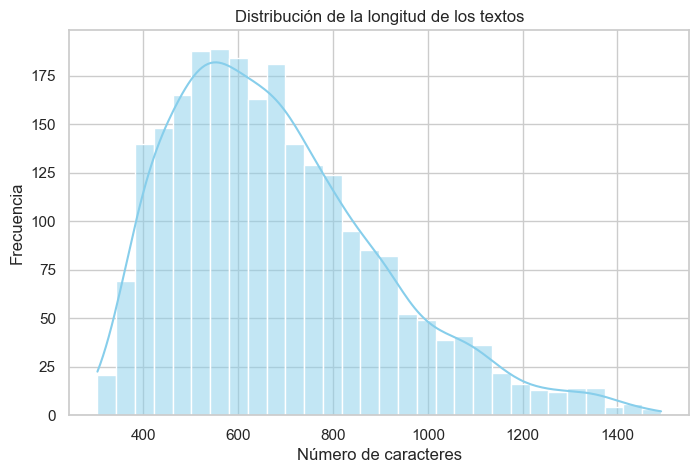

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["longitud"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

## 1.2 Distribución de la variable objetivo

Observamos el balance de clases para el atributo "labels".

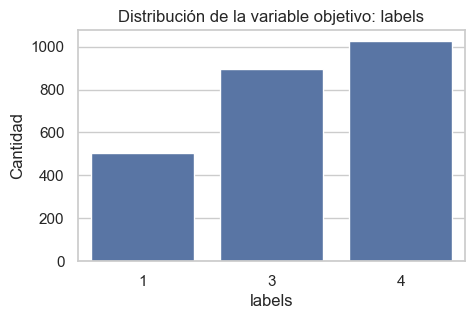

In [6]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

# 2. Limpieza y preparación de datos

In [7]:
df = df.drop_duplicates(subset="textos")
print(df.shape)

(2424, 3)


In [8]:
df = df.dropna(subset=["textos", "labels"])
print(df.shape)

(2424, 3)


## 2.1 Normalización

1. Pasar todo a minúsculas
2. Eliminar acentos
3. Eliminar caractéres especiales
4. Eliminar espacios adicionales

In [9]:
n_norm = 0

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Pasar a minúsculas
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore').decode("utf-8")  # Eliminar acentos
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip() # Eliminar espacios extra
    return text

df["textos"] = df["textos"].apply(normalize_text)

print("Ejemplo de normalizacion: " + df["textos"].iloc[0])  # Ejemplo de texto normalizado

Ejemplo de normalizacion: aprendizaje y educacion se consideran sinonimos de escolarizacion formal las organizaciones auxiliares como las editoriales de educacion las juntas examinadoras y las organizaciones de formacion de docentes se consideran extensiones de los acuerdos establecidos por los gobiernos este marco de comprension se ha vuelto cada vez mas inadecuado


## 2.2 Tokenización

In [11]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))
print(len(stop_words), "stopwords cargadas")
for i in range(int(len(stop_words)/10) + 1):
    print(list(stop_words)[i*10:(i+1)*10])
print(stop_words)

313 stopwords cargadas
['ti', 'estuvimos', 'os', 'tendrían', 'estuvieron', 'son', 'habido', 'o', 'tuvieran', 'pero']
['nuestros', 'había', 'tuyo', 'tenidos', 'hubiera', 'cuando', 'otro', 'éramos', 'tendrás', 'muchos']
['has', 'hubiésemos', 'habrías', 'estaríais', 'fuiste', 'este', 'lo', 'tened', 'estaba', 'hubieran']
['seamos', 'esa', 'estaremos', 'tuya', 'quien', 'las', 'el', 'algo', 'estuvieseis', 'hayas']
['hubiese', 'otras', 'mis', 'esas', 'estad', 'cual', 'habrán', 'seré', 'del', 'teniendo']
['suyos', 'estamos', 'entre', 'hubiesen', 'nuestra', 'tendréis', 'otros', 'sentidas', 'antes', 'tendré']
['habíais', 'tuviéramos', 'tenida', 'habrá', 'estas', 'siente', 'he', 'tenga', 'erais', 'hemos']
['hubieron', 'seas', 'en', 'seríais', 'sentid', 'durante', 'sin', 'esos', 'tenías', 'más']
['nosotros', 'somos', 'mía', 'estados', 'fueron', 'teníamos', 'hasta', 'nosotras', 'tuvieron', 'tendrá']
['tú', 'una', 'estaban', 'habéis', 'fueras', 'hayan', 'hubieras', 'estén', 'tienes', 'era']
['estuvi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["textos_limpios"] = df["textos"].apply(remove_stopwords)

print("Ejemplo de texto limpio: " + df["textos_limpios"].iloc[0])  # Ejemplo de texto limpio

Ejemplo de texto limpio: aprendizaje educacion consideran sinonimos escolarizacion formal organizaciones auxiliares editoriales educacion juntas examinadoras organizaciones formacion docentes consideran extensiones acuerdos establecidos gobiernos marco comprension vuelto cada vez mas inadecuado


## 2.3 Lematización

Opcional.

In [18]:
import spacy
from tqdm import tqdm

# Carga del modelo en español
nlp = spacy.load("es_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Aplica a la columna de texto limpio que ya tienes (ajusta el nombre si difiere)
tqdm.pandas()  # barra de progreso
df["texto_lema"] = df["textos"].astype(str).progress_apply(lemmatize_text)

df[["textos", "texto_lema"]].head(10)


100%|██████████| 2424/2424 [00:40<00:00, 60.39it/s]


,textos,texto_lema
0,aprendizaje y educacion se consideran sinonimo...,aprendizaje educacion considerar sinonimo esco...
1,para los ninos mas pequenos bebes y ninos pequ...,nino pequeno bebes nino pequeno capacitacion e...
2,ademas la formacion de especialistas en medici...,formacion especialista medicina general inclui...
3,en los paises de la ocde se tiende a pasar de ...,país ocde tender pasar curso obligatorio optat...
4,este grupo se centro en las personas que padec...,grupo centrar persona padecer trastorno mental...
5,los datos a nivel del sistema que no se deriva...,dato nivel sistema derivar cuestionario estudi...
6,la principal ventaja de las evaluaciones exter...,principal ventaja evaluación externo fiabilida...
7,los pacientes pueden elegir a cualquier medico...,paciente elegir medico cabecera sistema contro...
8,de hecho es probable que la designacion de la ...,probable designacion universidad universidad a...
9,de hecho aunque chile y uruguay tienen indices...,chile uruguay indiz pobreza similar pobreza in...


## 2.4 Visualización palabras más repetidas

In [13]:
from collections import Counter

all_text = " ".join(df["textos_limpios"])
tokens = all_text.split()

# Contar frecuencia de cada palabra
word_freq = Counter(tokens)

# Mostrar las 20 más comunes
for palabra, freq in word_freq.most_common(20):
    print(f"{palabra}: {freq}")


mas: 1797
salud: 1107
pobreza: 1019
educacion: 992
paises: 962
atencion: 900
tambien: 767
estudiantes: 741
ocde: 587
escuelas: 586
anos: 559
servicios: 548
nivel: 521
sistema: 508
ninos: 479
personas: 457
pueden: 453
calidad: 447
desarrollo: 439
resultados: 416


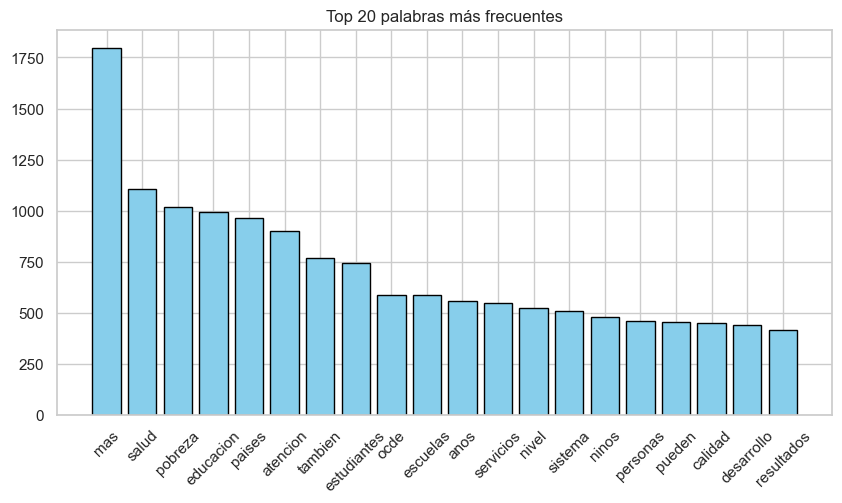

In [14]:
# Convertir a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=["Palabra", "Frecuencia"])

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(freq_df["Palabra"], freq_df["Frecuencia"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45)
plt.title("Top 20 palabras más frecuentes")
plt.show()


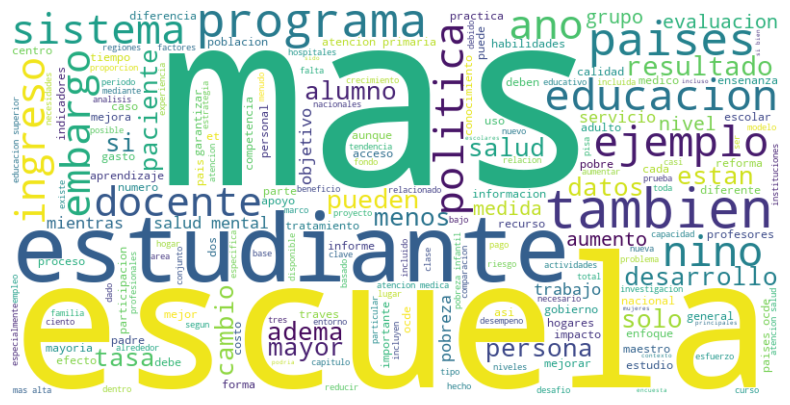

In [16]:

all_text = " ".join(df["textos_limpios"])
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


## 2.5 Vectorización

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# === Config ===
TEXT_COL  = "texto_lema"   # columna con los textos ya lematizados
LABEL_COL = "labels"       # ajusta si tu columna de clase se llama distinto

# === Split train / valid ===
X = df[TEXT_COL]
y = df[LABEL_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamaño train:", len(X_train), "| validación:", len(X_val))

# === Vectorizador TF-IDF ===
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),   # unigrams + bigrams
    min_df=3,            # descartar términos raros
    max_df=0.9,          # descartar términos demasiado comunes
    sublinear_tf=True,   # log-scaling en TF
    norm="l2"
)

# Ajustar en train y transformar
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)

print("Shape train:", X_train_tfidf.shape, "| Shape valid:", X_val_tfidf.shape)
print("Tamaño vocabulario:", len(vectorizer.get_feature_names_out()))

# Vista de algunas features
print("Ejemplo de términos:", vectorizer.get_feature_names_out()[:30])


Tamaño train: 1939 | validación: 485
Shape train: (1939, 6868) | Shape valid: (485, 6868)
Tamaño vocabulario: 6868
Ejemplo de términos: ['000' '000 estudiante' '000 habitante' '01' '02' '03' '04' '048' '05'
 '06' '07' '07 punto' '09' '10' '10 ano' '10 ciento' '10 país' '100'
 '100 000' '1000' '1000 habitante' '103' '104' '11' '112' '114' '118' '12'
 '12 ano' '121']


# 3. División train/test

In [20]:
from sklearn.model_selection import train_test_split

# Definimos X (features) e y (target)
X = df["texto_lema"]     # textos ya lematizados
y = df["labels"]         # AJUSTA si tu columna de clase tiene otro nombre

# División estratificada para balancear las clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,
    stratify=y           # mantiene la proporción de las clases
)

print("Tamaño total:", len(df))
print("Train:", len(X_train))
print("Test :", len(X_test))
print("\nDistribución de clases en train:")
print(y_train.value_counts(normalize=True).round(3))
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True).round(3))


Tamaño total: 2424
Train: 1939
Test : 485

Distribución de clases en train:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64

Distribución de clases en test:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64


## 3.1 Vectorización con TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    norm="l2"
)

X_train_tfidf = vectorizer.fit_transform(X_train)  # SOLO fit en train
X_test_tfidf  = vectorizer.transform(X_test)       # transform en test

print("Shape train:", X_train_tfidf.shape, " | Shape test:", X_test_tfidf.shape)
print("Vocabulario:", len(vectorizer.get_feature_names_out()))


Shape train: (1939, 6868)  | Shape test: (485, 6868)
Vocabulario: 6868


## 3.2 Guardar el vectorizador

In [22]:
from joblib import dump
dump(vectorizer, "tfidf_vectorizer.joblib")
print("Vectorizador guardado en tfidf_vectorizer.joblib")


Vectorizador guardado en tfidf_vectorizer.joblib


## 3.3 Checks rápidos de calidad
Opcional

In [23]:
import numpy as np

# Densidad (sparsity): valores no-cero / total
train_density = X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])
test_density  = X_test_tfidf.nnz  / (X_test_tfidf.shape[0]  * X_test_tfidf.shape[1])

print(f"Densidad train: {train_density:.4f}  | Densidad test: {test_density:.4f}")

# Echar un vistazo a algunos términos
terms = vectorizer.get_feature_names_out()
print("Ejemplos de términos:", terms[:30])


Densidad train: 0.0069  | Densidad test: 0.0065
Ejemplos de términos: ['000' '000 estudiante' '000 habitante' '01' '02' '03' '04' '048' '05'
 '06' '07' '07 punto' '09' '10' '10 ano' '10 ciento' '10 país' '100'
 '100 000' '1000' '1000 habitante' '103' '104' '11' '112' '114' '118' '12'
 '12 ano' '121']
